# **Part 3 - Model Tuning**<br>
In this part we will upsample the previously upsampled data. If You remember, in M1(part2a) - Base Approach 1, we slightly upsampled the data and made all the classes having less than 10 records equal to 10. We did that for a different purpose then (refer M1(part2a) - Base Approach 1 for more details), but here we will upsample to have adequate samples for minority classes so that they could be trained and understood by the model.<br>We will take that previously upsampled data and upsample it further for the same.<br><br>
**Note that: Most of the steps here are repetitive from previous notebooks, hence we won't explain it here, but we will mention the notebook where it is explained**

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/capstone')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from ProjectModules.PlottingModule import distribution_plot, plot_count_plot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, GlobalMaxPool1D
from Model.DLModelTuningAndEvaluation import *
from imblearn.over_sampling import RandomOverSampler

# clean this
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, GlobalMaxPool1D, Flatten
from Model.DLModelTuningAndEvaluation import *
from keras.models import load_model
import math
from sklearn.metrics import recall_score, precision_score, classification_report

Loading previously upsampled data that we saved in **M1(part2a) - Base Approach 1**

In [ ]:
# RUN THIS DATAPATH IF RUNNING IN GOOGLE COLAB, GIVE THE CORRECT PATH TO THE DATA
DATAPATH = '/content/drive/MyDrive/capstone/DataFiles/'
# *************************** --------------------------************************************
# DATAPATH = 'DataFiles/'

data = pd.read_csv(DATAPATH+"upsampled_processed_data.csv")
df = data.copy() #making copy of the data
print(df.shape)
df.head()

(8040, 4)


,cleaned_short_desc,cleaned_desc,combined_tokens,Assignment group
0,login issue,verify user detail employee manager name check...,login issue verify user detail employee manage...,GRP_0
1,outlook,team meeting skype meeting etc appear outlook ...,outlook team meeting skype meeting etc appear ...,GRP_0
2,cant log vpn,cannot log vpn best,cant log vpn cannot log vpn best,GRP_0
3,unable access hr tool page,unable access hr tool page,unable access hr tool page unable access hr to...,GRP_0
4,skype error,skype error,skype error skype error,GRP_0


Dropping the combined_tokens column because we will combine it in a different way. **(refer to M1(part2b) - Base Approach 2)**

In [ ]:
df.drop("combined_tokens", inplace=True, axis=1)
df.head()

,cleaned_short_desc,cleaned_desc,Assignment group
0,login issue,verify user detail employee manager name check...,GRP_0
1,outlook,team meeting skype meeting etc appear outlook ...,GRP_0
2,cant log vpn,cannot log vpn best,GRP_0
3,unable access hr tool page,unable access hr tool page,GRP_0
4,skype error,skype error,GRP_0


We have some missing values, but we will retain them and replace them with empty strings. **(refer to M1(part2a) - Base Approach 1 to know how and why)**

In [ ]:
df.isnull().sum()

cleaned_short_desc    16
cleaned_desc          52
Assignment group       0
dtype: int64

Despite missing values, we can see that there is no such row where both description and short description are empty

In [ ]:
df[(df['cleaned_short_desc'].isnull()) & (df['cleaned_desc'].isnull())]

,cleaned_short_desc,cleaned_desc,Assignment group


Replacing NaNs with empty strings as said above

In [ ]:
df['cleaned_short_desc'].fillna(value="",inplace=True)
df['cleaned_desc'].fillna(value = "",inplace=True)

**Now we will upsample:**<br>
If we look at the top 5 records, except first 2 groups, all are below 300 and skewes even further which we have already seen. We also seen that most of the groups have around 70-150 records only and some go as low as just 10 records.<br>The model performs averagely for groups that have 70, 100, 200 records (that we saw in support column of the classification report) and very poorly for records that are below 50. The training is overshadowed by the first few groups below (the top 5) ,specially by group 0 and group 8<br>Thus we will upsample all the groups below 300... to 300. This means that from group 24, all the groups will be upsampled<br><br>**WHAT HAPPENS WHEN WE UPSAMPLE TEXT DATA?**<br>When we upsample test data, it will simply create duplicate records for that particular group in order to increase its sample size and make it recognizable to the model. Eg: Lets say a group has 20 records. During upsampling, a record from these 20 records will be picked and duplicated, and this process repeats untill that group has 300 records (which is set by us) 

Top 20 groups:

GRP_0     3428
GRP_8      645
GRP_24     285
GRP_12     256
GRP_9      252
GRP_2      241
GRP_19     214
GRP_3      200
GRP_6      183
GRP_13     145
GRP_10     140
GRP_5      128
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4       99
GRP_29      97
GRP_18      88
GRP_16      85
GRP_17      68
Name: Assignment group, dtype: int64 



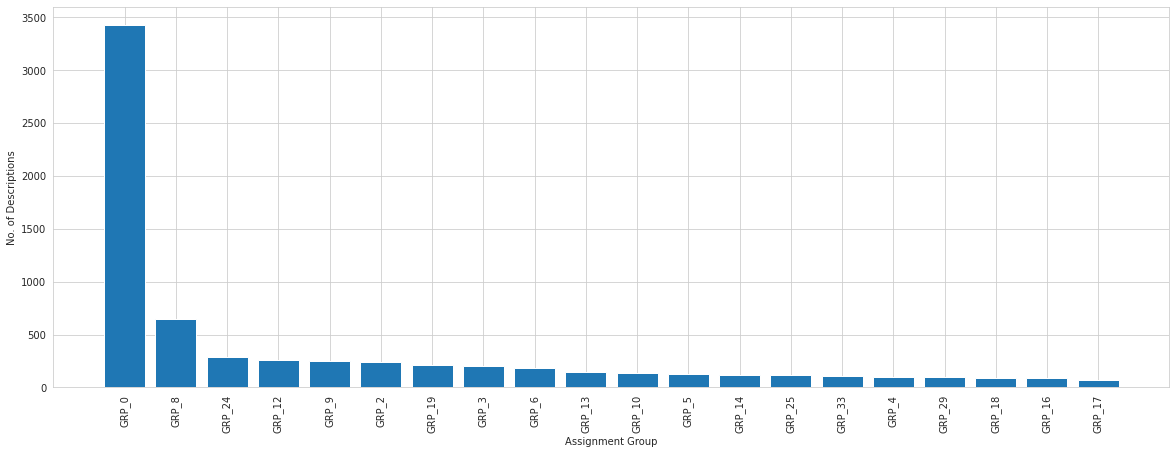

In [ ]:
xlabel = "Assignment Group"
ylabel = "No. of Descriptions"
values = df["Assignment group"].value_counts().head(20).to_dict().values()
labels = df["Assignment group"].value_counts().head(20).to_dict().keys()
print("Top 20 groups:\n")
print(df["Assignment group"].value_counts().head(20),"\n")
plot_count_plot(values,labels,xlabel,ylabel)

This will be our upsampling strategy. Leaving the first 2 groups (0 and 8), all others will be upsampled to 300. We will put this dictionary in the sampling_strategy parameter of the Sklearn's RandomOverSampler package


In [ ]:
upsampleto300 = df["Assignment group"].value_counts()[2:].keys().to_list()
upsample_strategy = {i:300 for i in upsampleto300}
upsample_strategy   

{'GRP_1': 300,
 'GRP_10': 300,
 'GRP_11': 300,
 'GRP_12': 300,
 'GRP_13': 300,
 'GRP_14': 300,
 'GRP_15': 300,
 'GRP_16': 300,
 'GRP_17': 300,
 'GRP_18': 300,
 'GRP_19': 300,
 'GRP_2': 300,
 'GRP_20': 300,
 'GRP_21': 300,
 'GRP_22': 300,
 'GRP_23': 300,
 'GRP_24': 300,
 'GRP_25': 300,
 'GRP_26': 300,
 'GRP_27': 300,
 'GRP_28': 300,
 'GRP_29': 300,
 'GRP_3': 300,
 'GRP_30': 300,
 'GRP_31': 300,
 'GRP_32': 300,
 'GRP_33': 300,
 'GRP_34': 300,
 'GRP_35': 300,
 'GRP_36': 300,
 'GRP_37': 300,
 'GRP_38': 300,
 'GRP_39': 300,
 'GRP_4': 300,
 'GRP_40': 300,
 'GRP_41': 300,
 'GRP_42': 300,
 'GRP_43': 300,
 'GRP_44': 300,
 'GRP_45': 300,
 'GRP_46': 300,
 'GRP_47': 300,
 'GRP_48': 300,
 'GRP_49': 300,
 'GRP_5': 300,
 'GRP_50': 300,
 'GRP_51': 300,
 'GRP_52': 300,
 'GRP_53': 300,
 'GRP_54': 300,
 'GRP_55': 300,
 'GRP_56': 300,
 'GRP_57': 300,
 'GRP_58': 300,
 'GRP_59': 300,
 'GRP_6': 300,
 'GRP_60': 300,
 'GRP_61': 300,
 'GRP_62': 300,
 'GRP_63': 300,
 'GRP_64': 300,
 'GRP_65': 300,
 'GRP_66': 300

In [ ]:
# saving names of the feature columns
featnames = list(df.columns[:2])

# seperating features and target
targetcolumn = df["Assignment group"].values
feats = df.drop(['Assignment group'],axis=1).values

# initializing RandomOverSampler
oversample = RandomOverSampler(sampling_strategy=upsample_strategy, random_state=7)
others_up, target_up = oversample.fit_resample(X=feats,y=targetcolumn)
others_up = pd.DataFrame(others_up,columns=featnames)
target_up = pd.DataFrame(target_up,columns=["Assignment group"])

# concatinating features and target after upsampling
df = pd.concat([others_up,target_up],axis=1)
print("dataset size after upsampling:",df.shape[0])
df.head()

dataset size after upsampling: 25673


,cleaned_short_desc,cleaned_desc,Assignment group
0,login issue,verify user detail employee manager name check...,GRP_0
1,outlook,team meeting skype meeting etc appear outlook ...,GRP_0
2,cant log vpn,cannot log vpn best,GRP_0
3,unable access hr tool page,unable access hr tool page,GRP_0
4,skype error,skype error,GRP_0


**All records have been upsampled to 300 except first 2. Again plotting top 20 groups:**

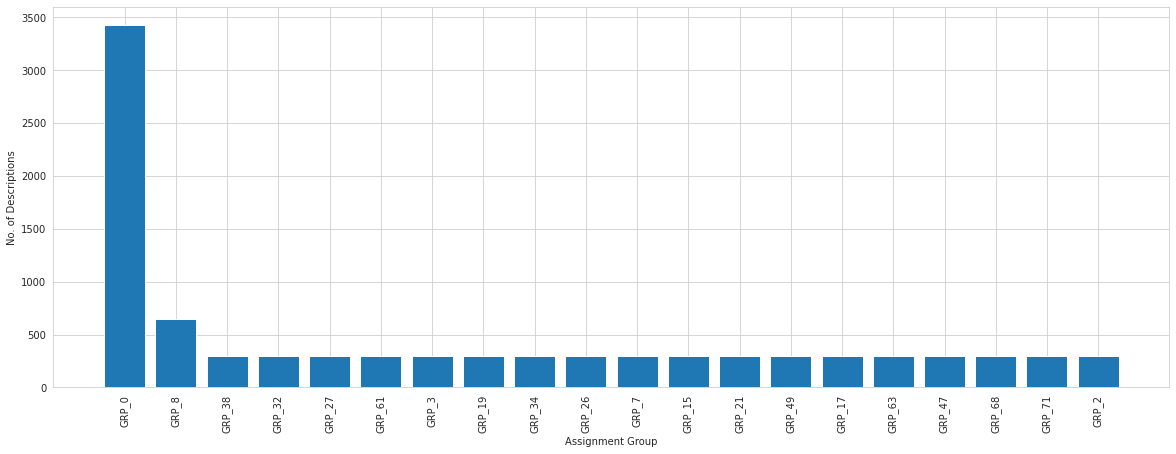

In [ ]:
xlabel = "Assignment Group"
ylabel = "No. of Descriptions"
values = df["Assignment group"].value_counts().head(20).to_dict().values()
labels = df["Assignment group"].value_counts().head(20).to_dict().keys()
plot_count_plot(values,labels,xlabel,ylabel)

Making vocabulary **(same as M1(part2b) - Base Model Approach 2)**

In [ ]:
vocabulary = set()

for txt in df["cleaned_desc"]:
    unq_words = set(txt.split())
    vocabulary.update(unq_words)

for txt in df["cleaned_short_desc"]:
    unq_words = set(txt.split())
    vocabulary.update(unq_words)

# appending 'DUMMYWORD' which will be helpful in padding
vocabulary = list(vocabulary)
vocabulary.append("DUMMYWORD")

print("Total unique words in the vocabulary from both description and short description:",len(vocabulary))

Total unique words in the vocabulary from both description and short description: 19235


Converting vocabulary to numerical values **(same as M1(part2b) - Base Model Approach 2)**

In [ ]:
# mapping vocabulary to numbers
vocab2id = {w: i for i, w in enumerate(vocabulary)}

# mapping numbers to vocabulary
id2vocab = {v: k for k, v in vocab2id.items()}

# transforming dataset to numerical tokens
def convert_words_to_numbers(txt):
  return [vocab2id[i] for i in txt.split()]

# transforming
df["desc_transformed"] = df["cleaned_desc"].apply(convert_words_to_numbers)
df["shortdesc_transformed"] = df["cleaned_short_desc"].apply(convert_words_to_numbers)

As we said before we will club them in a different way **(find the explanation in M1(part2b) - Base Model Approach 2)**

In [ ]:
def clubbing_columns(row):
  if(row["shortdesc_transformed"] == row["desc_transformed"]):
    return row["desc_transformed"]
  else:
    return row["shortdesc_transformed"] + row["desc_transformed"]


df["combined_tokens"] = df[["shortdesc_transformed","desc_transformed"]].apply(clubbing_columns, axis=1)
df.head()

,cleaned_short_desc,cleaned_desc,Assignment group,desc_transformed,shortdesc_transformed,combined_tokens
0,login issue,verify user detail employee manager name check...,GRP_0,"[17381, 13217, 6236, 18242, 3944, 11151, 16545...","[14603, 8989]","[14603, 8989, 17381, 13217, 6236, 18242, 3944,..."
1,outlook,team meeting skype meeting etc appear outlook ...,GRP_0,"[6671, 7721, 17441, 7721, 6383, 15390, 2738, 6...",[2738],"[2738, 6671, 7721, 17441, 7721, 6383, 15390, 2..."
2,cant log vpn,cannot log vpn best,GRP_0,"[14248, 19078, 8110, 13022]","[15068, 19078, 8110]","[15068, 19078, 8110, 14248, 19078, 8110, 13022]"
3,unable access hr tool page,unable access hr tool page,GRP_0,"[18617, 9805, 7963, 10404, 940]","[18617, 9805, 7963, 10404, 940]","[18617, 9805, 7963, 10404, 940]"
4,skype error,skype error,GRP_0,"[17441, 18965]","[17441, 18965]","[17441, 18965]"


Checking for null values again

In [ ]:
df.isnull().sum()

cleaned_short_desc       0
cleaned_desc             0
Assignment group         0
desc_transformed         0
shortdesc_transformed    0
combined_tokens          0
dtype: int64

As before, transforming the target variable **(find explanation in M1(part2b) - Base Model Approach 2)**

In [ ]:
df=pd.get_dummies(df, columns=['Assignment group'])

ynames = list(df.iloc[:,5:].columns)
y = df.iloc[:,5:].values
x = df["combined_tokens"]

print('y (target) in a one-hot binarizer form:',y.shape)
print('features:',x.shape)

y (target) in a one-hot binarizer form: (25673, 74)
features: (25673,)


Transforming combined tokens into sequence **(same as M1(part2b) - Base Model Approach 2)**

 Max no. of tokens in short description (sequence):  1820
 Avg. no. of tokens in short description (sequence):  33.08
 90% of the sequences are <= 52.0
 95% of the sequences are <= 83.0


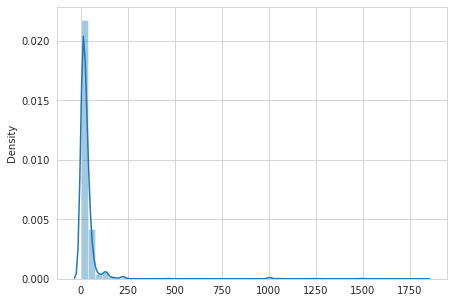

In [ ]:
x_seq = [seq for seq in x]

size_of_sequences = [len(i) for i in x]

percentile90 = round(np.percentile(a=size_of_sequences, q=90),2)
percentile95 = round(np.percentile(a=size_of_sequences, q=95),2)
mean_size = round(np.mean(size_of_sequences),2) 
max_size = round(np.max(size_of_sequences),2)

print(" Max no. of tokens in short description (sequence): ",max_size)
print(" Avg. no. of tokens in short description (sequence): ",mean_size)
print(" 90% of the sequences are <=",percentile90)
print(" 95% of the sequences are <=",percentile95)
distribution_plot(size_of_sequences)

95% of the sequences are 83 or below, hence we will pad all sequences to 83 and we will pad with the number 19234 which encodes the word 'DUMMYWORD' **(same as M1(part2b) - Base Model Approach 2)**

In [ ]:
# 19234 encodes 'DUMMYWORD'
id2vocab[19234]

'DUMMYWORD'

In [ ]:
x_pad = pad_sequences(maxlen=83, sequences=x_seq, padding="pre", value=len(vocabulary)-1)

print("shape of x before padding",np.array(x_seq).shape)
print("shape of x after padding",x_pad.shape)

shape of x before padding (25673,)
shape of x after padding (25673, 83)


Now that we have more data, **we can make a 70:30 split:**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_pad, y, test_size=0.3, train_size=0.7, random_state=777, stratify=y)
print("train set",x_train.shape)
print("train labels",y_train.shape,"\n\n")
print("test set",x_test.shape)
print("test labels",y_test.shape)

train set (17971, 83)
train labels (17971, 74) 


test set (7702, 83)
test labels (7702, 74)


Since the vocabulary is same (we have just duplicated the records), we can load the previous glove embedding matrix that we saved in **M1(part2b) - Base Model Approach 2** 

In [ ]:
# USE THIS SAVEPATH IF RUNNING IN GOOGLE COLAB, GIVE THE PATH WHERE YOU WANT TO SAVE
SAVEPATH = '/content/drive/MyDrive/capstone/DataFiles/Milestone2/'
# *************************** --------------------------************************************
# SAVEPATH = 'DataFiles/Milestone2/'

embedding_matrix = np.load(SAVEPATH+'GloveEmbeddingMatrix.npy')
print(embedding_matrix.shape)

(19235, 200)


**As we said in previous part we will take model_5 forward along with learning rate = 0.00162 which we tuned in the last part.<br>We will go with the same training process again but with new upsampled data. We just have a few minor changes:**<br>
- We have reduced the **patience for early stopping to 5 from 10**
- Now that we have more data, we have **increased the batch size to 32 from 16**
- Again, since we have more data, the model will aggresively overfit, hence **we have increased the dropout rate to 40%**
- And finally, **we will monitor validation_loss instead of validation_accuracy to save the model_checkpoint.** The model at epoch with least validation_loss will be saved

In [ ]:
input = Input(shape=(x_train.shape[1],),batch_size=None)
model5 = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=x_train.shape[1], trainable=True)(input)
model5 = LSTM(units=100, return_sequences=True,recurrent_dropout=0.4)(model5)
model5 = GlobalMaxPool1D()(model5)
model5 = Dropout(0.4)(model5) 
out = Dense(y_train.shape[1], activation="softmax")(model5)
model5 = Model(input, out)

es_params = {'monitor':'loss', 'min_delta':0.1, 'patience':5, 'verbose':1, 'mode':'min', 'restore_best_weights':True}
r_lr_params = {'monitor':'val_loss', "factor":0.1, 'patience':3, 'verbose':1, 'mode':'min', 'min_delta':0.01, 'min_lr':1e-7}
m_cp_params = {"chkpnt_filename":"model5_afterupsampling", "monitor":'val_loss', "verbose":1, "save_best_only":True, "mode":'min'}


model5 = train_model(model5, x_train, y_train, x_test, y_test, ep=50, bs=32, learn_rate=0.00162,callbacks=True, earlystop_params=es_params, modelchkpnt_params=m_cp_params, reducelr_params=r_lr_params)

Epoch 1/50
562/562 [==============================] - 171s 302ms/step - loss: 3.0629 - accuracy: 0.3262 - val_loss: 1.0667 - val_accuracy: 0.7441

Epoch 00001: val_loss improved from inf to 1.06673, saving model to /content/drive/My Drive/capstone/Model/model checkpoints/model5C_afterupsampling.h5
Epoch 2/50
562/562 [==============================] - 170s 302ms/step - loss: 1.0078 - accuracy: 0.7488 - val_loss: 0.5560 - val_accuracy: 0.8625

Epoch 00002: val_loss improved from 1.06673 to 0.55599, saving model to /content/drive/My Drive/capstone/Model/model checkpoints/model5C_afterupsampling.h5
Epoch 3/50
562/562 [==============================] - 170s 302ms/step - loss: 0.5276 - accuracy: 0.8750 - val_loss: 0.3927 - val_accuracy: 0.8915

Epoch 00003: val_loss improved from 0.55599 to 0.39268, saving model to /content/drive/My Drive/capstone/Model/model checkpoints/model5C_afterupsampling.h5
Epoch 4/50
562/562 [==============================] - 167s 298ms/step - loss: 0.3000 - accuracy

Training history saved!


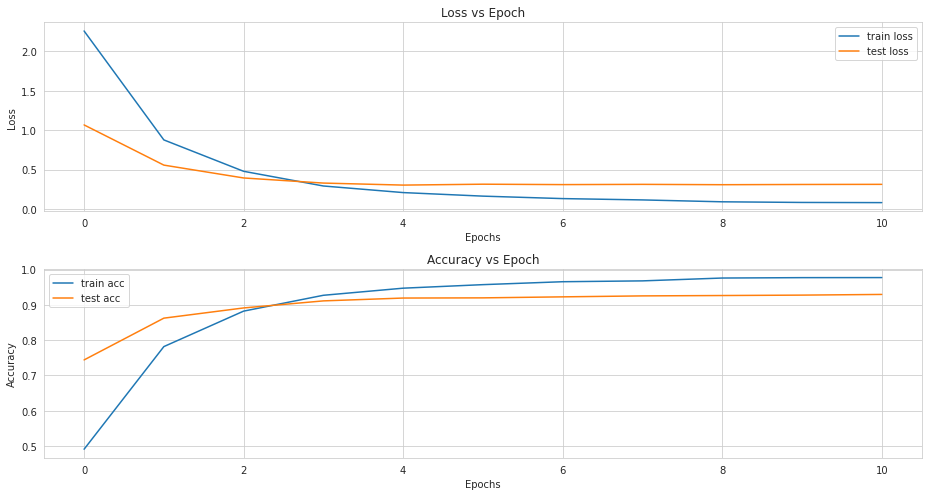

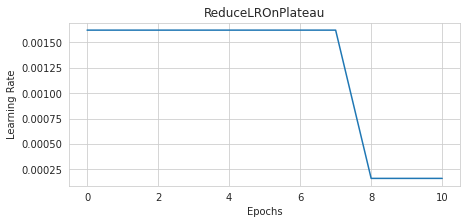

In [ ]:
show_training(model5.history.history,saveit=True,filename='model5_hist_afterupsampling')

In [ ]:
saved_checkpoint_model5 = load_model("/content/drive/MyDrive/capstone/Model/model checkpoints/model5_afterupsampling.h5")

In [ ]:
ytr_pred = saved_checkpoint_model5.predict(x_train,batch_size=1)
yte_pred = saved_checkpoint_model5.predict(x_test,batch_size=1)

print("Train set performance:")
DL_evaluation_metrics(y_train, ytr_pred, "ovo", "macro")

print("\nTest set performance:")
DL_evaluation_metrics(y_test, yte_pred, "ovo", "macro")

print("\n**As explained in part2a - micro-metrics will be similar to accuracy")

Train set performance:
Accuracy: 0.9713983640309387
(macro) ROC-AUC: 0.9997131408720261
(macro) F1 Score: 0.9746532702542502

Test set performance:
Accuracy: 0.9195014282004674
(macro) ROC-AUC: 0.99724265540487
(macro) F1 Score: 0.9317530012493747

**As explained in part2a - micro-metrics will be similar to accuracy


In [ ]:
print("Train set:\n")
print(classification_report(y_true=y_train.argmax(axis=1), y_pred=ytr_pred.argmax(axis=1)))

print("\nTest set:\n")
print(classification_report(y_true=y_test.argmax(axis=1), y_pred=yte_pred.argmax(axis=1)))

Train set:

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2400
           1       0.98      1.00      0.99       210
           2       0.98      0.98      0.98       210
           3       1.00      0.99      0.99       210
           4       0.96      0.93      0.94       210
           5       1.00      0.97      0.98       210
           6       0.98      0.94      0.96       210
           7       1.00      1.00      1.00       210
           8       1.00      1.00      1.00       210
           9       1.00      1.00      1.00       210
          10       0.99      0.99      0.99       210
          11       0.82      0.78      0.80       210
          12       0.94      0.88      0.91       210
          13       0.89      1.00      0.94       210
          14       1.00      1.00      1.00       210
          15       1.00      1.00      1.00       210
          16       0.99      1.00      0.99       210
          17   